### 1. Download the datasets from the course website, unzip (7z program) and load it with pandas.
### (Hint: df = pd.read_json("..json", orient='records', lines=True)
### Use the following site from arxiv (https://arxiv.org/category_taxonomy) to taxonomize the documents into 5 categories: {0:'Computer Science', 1:'Mathematics', 2:'Statistics', 3:'Economics', 4:'EESS'}. This will constitute the ground truth. To create labels, use the first category entry.
### (Hint: Use the regular expression re.search(r'^([\w\-]+)', cat.split(' ')[0]).group(1) on the categories column. Check: [110347, 130726, 13920, 924, 7252] and [111091, 130287, 13672, 871, 7249] in training and testing sizes, respectively)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re


# Load the training and testing datasets
df_train = pd.read_json("arxiv_training.json", orient='records', lines=True)
df_test = pd.read_json("arxiv_testing.json", orient='records', lines=True)


In [2]:
def sanitize(cat):
    sant = re.search(r'^([\w\-]+)', cat.split(' ')[0]).group(1)
    return sant if sant in {'cs', 'stat', 'math', 'econ', 'eess'} else 'NA'

df_train['categories'] = df_train['categories'].apply(sanitize)
df_test['categories'] = df_test['categories'].apply(sanitize)

df_train['update_date'] = pd.to_datetime(df_train['update_date'])
df_test['update_date'] = pd.to_datetime(df_test['update_date'])

df_train = df_train[(df_train['categories'] != 'NA') & (df_train['update_date'].dt.year >= 2010)]
df_test = df_test[(df_test['categories'] != 'NA') & (df_test['update_date'].dt.year >= 2010)]

### 2. [30 pts] Classify the documents and report testing accuracy (confusion matrix?).
### (Hint: Use TfidfVectorizer with a Pipeline. If you use a random forest make sure the max_depth parameter is reasonable, i.e. <30, to make sure it finishes faster. Any classifier you use has to know how to deal with sparse matrices.)

In [3]:
# # Split the data into training and testing sets
X_train, y_train = df_train['abstract'], df_train['categories']
X_test, y_test = df_test['abstract'], df_test['categories']

In [4]:
# Create a pipeline with CountVectorizer, TfidfTransformer, and a MultinomialNB classifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler  # Example data preprocessing step
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
N_FEATURES=10
pipeline = Pipeline([('scaler', TfidfVectorizer()),  # Standardize the data
    ('classifier', LogisticRegression(max_iter=100)),
                   ])
pipeline.fit(X_train, y_train)
# Predict the categories on the test data
y_pred = pipeline.predict(X_test)
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", accuracy)

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing Accuracy: 0.8971588119997632
Confusion Matrix:
[[106964     21   1141   6762   1509]
 [   363    138      0    181    210]
 [  5366      3   1288    476     84]
 [  5490     17    140 141403   1432]
 [  4426     32     54   1833   7906]]


In [5]:
from sklearn.metrics import accuracy_score, classification_report
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_rep)

Accuracy: 0.8971588119997632
              precision    recall  f1-score   support

          cs       0.87      0.92      0.90    116397
        econ       0.65      0.15      0.25       892
        eess       0.49      0.18      0.26      7217
        math       0.94      0.95      0.95    148482
        stat       0.71      0.55      0.62     14251

    accuracy                           0.90    287239
   macro avg       0.73      0.55      0.60    287239
weighted avg       0.89      0.90      0.89    287239



### State the class with the least performance. Why?

The class with the least performance is econ and eess. The reason for this is largely due to two things. The first thing is that eess and econ both contain the smallest number of entries, which can lead to a less accurate definer. The next issue is that the classifier is overwhelmingly skewed towards falsely identifying eess and econ as a computer science paper. This is likely due to the fact that a large number of papers hee =

### 3. [30 pts] Apply POS processing and pick only nouns as tokens (i.e., <NN>+, <NNP>+, etc.).
### Repeat and report any classification improvement in your pipeline in (2.).
### Can you suggest other tags to improve the pipeline?
### (Note that POS will take a long time (up to 1 hour) in this large dataset and suggest saving the tokens in another DataFrame. In addition, once tokenized and stored one can use TfidfVectorizer(tokenizer=lambda x:x, lowercase=False) to work on the tokenized list directly. Make sure you test your tagger on small datasets first. Suggest PerceptronTagger())

In [6]:
#abs_df_train=df_train['abstract']
#cat_df_train=df_train['categories']

In [7]:
def extract_nouns(text):
    # Tokenize the text using a regular expression tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # Perform POS tagging on the tokens using the PerceptronTagger
    pos_tags = PerceptronTagger().tag(tokens)
    
    # Extract nouns (NN, NNS, NNP, NNPS)
    nouns = [token for token, pos in pos_tags if pos in ['NN', 'NNS', 'NNP', 'NNPS']]
    
    return nouns

In [8]:
# used to save the POS taggers to a csv file

# from nltk.tokenize import RegexpTokenizer
# from nltk.tag import PerceptronTagger
# df_nouns = pd.DataFrame()
# df_nouns['nouns'] = test

# # Save this new DataFrame for future use, as POS tagging can be time-consuming
# df_nouns.to_csv('nouns.csv', index=False)

In [9]:
nouns_test=pd.read_csv('nouns_test.csv')
# nouns_train=pd.read_csv('nouns_train.csv')

In [10]:
nouns_train=pd.read_csv('nouns_train.csv')

In [11]:
X_train,X_test,y_train,y_test = nouns_train['nouns'].str.replace(r'[,\]]', '', regex=True),nouns_test['nouns'].str.replace(r'[,\]]', '', regex=True),df_train['categories'],df_test['categories']

In [12]:
N_FEATURES=10
pipeline = Pipeline([('scaler', TfidfVectorizer()),  # Standardize the data
    ('classifier', LogisticRegression(max_iter=100,solver='sag')),
                   ])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', TfidfVectorizer()),
                ('classifier', LogisticRegression(solver='sag'))])

In [13]:
y_pred = pipeline.predict(X_test)
# # Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", accuracy)

# # Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Testing Accuracy: 0.8903700402800455
Confusion Matrix:
[[106260     15    995   7557   1570]
 [   369     99      0    201    223]
 [  5495      1   1064    572     85]
 [  5948     10    133 140951   1440]
 [  4622     26     51   2177   7375]]


##### Confusion Matrix from before:
##### [[106964     21   1141   6762   1509]
#####  [   363    138      0    181    210]
##### [  5366      3   1288    476     84]
##### [  5490     17    140 141403   1432]
##### [  4426     32     54   1833   7906]]
##### Confusion Matrix after:
##### [[105388     63   1413   7443   2090] DECREASE
##### [   331    162      0    182    217]  INCREASE
##### [  5170      3   1368    565    111]  INCREASE
##### [  6223     34    188 140598   1439]  DECREASE
##### [  4244     55     70   2303   7579]] DECREASE

# precision    recall  f1-score   support

#         cs       0.87      0.92      0.90    116397
#        econ       0.65      0.15      0.25       892
#        eess       0.49      0.18      0.26      7217
#        math       0.94      0.95      0.95    148482
#        stat       0.71      0.55      0.62     14251

#    accuracy                           0.90    287239
#   macro avg       0.73      0.55      0.60    287239
# weighted avg       0.89      0.90      0.89    287239



Overall, there does not seem to be a marked improvement in the overall prediction rate of the requirement, although there may be better improvements in some parts of the . One thing that might be causing this is the fact that a lot of the nouns may not hold a signifigant amount of information concerning how each of the values are actually chosen. One benefit of the model keeping only the nouns is that the prediction rate for the categories that performed poorly previously increased slightly, while those for the overrepresented categories went up.

# 4. [20 pts] Merge training and testing datasets then extract top-20 bigrams from the POS processed tokens in (3.) for every year from 2011 to the latest and plot/table top-20 bigrams for some of the publication categories. Do you see interesting emerging keywords?
# (We are ignoring the filtered-out terms in between these tokens)

In [14]:
df_train['nouns']=nouns_train
df_test['nouns']=nouns_test
# Drop rows with missing values in the 'nouns' column for df_train
df_train.dropna(subset=['nouns'], inplace=True)

# Drop rows with missing values in the 'nouns' column for df_test
df_test.dropna(subset=['nouns'], inplace=True)
df_concat= pd.concat([df_train,df_test],axis=0)



from collections import Counter

# Combine all the nouns for each year into a single list
try:
    df_concat['nouns'] = df_concat['nouns'].apply(lambda x : eval(x))
except:
    print('already str')
def generate_bigrams(lst):
    bigrams = []
    for i in range(len(lst) - 1):
        bigram = (lst[i], lst[i + 1])
        bigrams.append(bigram)
    return bigrams
df_concat['bigrams']= df_concat['nouns'].apply(generate_bigrams)


In [15]:
df_concat['update_date'] = pd.to_datetime(df_concat['update_date']).dt.year

In [16]:
# Import the required libraries
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'year' is a column in your dataframe containing the publication year

# Filter the data for years 2011 to the latest year
start_year = 2011  # Change this to your desired start year
end_year = df_concat['update_date'].max()  # Get the latest year from the dataset


In [17]:
for year in range(start_year, end_year + 1):
    # Filter the data for the current year
    year_data = df_concat[df_concat['update_date'] == year]

    # Flatten the list of bigrams for the current year
    all_bigrams = [bigram for bigrams in year_data['bigrams'] for bigram in bigrams]

    # Count the occurrences of each bigram
    bigram_counts = Counter(all_bigrams)

    # Get the top-20 bigrams for the current year
    top_20_bigrams = bigram_counts.most_common(20)

    # Display or save the top-20 bigrams for the current year
    print(f"Top 20 Bigrams for {year}:")
    for i, (bigram, count) in enumerate(top_20_bigrams, start=1):
        print(f"{i}. {bigram}: {count} occurrences")

Top 20 Bigrams for 2011:
1. ('state', 'art'): 1342 occurrences
2. ('mathbb', 'R'): 747 occurrences
3. ('graph', 'G'): 306 occurrences
4. ('machine', 'learning'): 294 occurrences
5. ('optimization', 'problem'): 262 occurrences
6. ('mathbb', 'Z'): 242 occurrences
7. ('time', 'series'): 235 occurrences
8. ('data', 'sets'): 234 occurrences
9. ('paper', 'problem'): 222 occurrences
10. ('Monte', 'Carlo'): 220 occurrences
11. ('R', 'd'): 209 occurrences
12. ('e', 'g'): 200 occurrences
13. ('training', 'data'): 198 occurrences
14. ('x', 'y'): 197 occurrences
15. ('O', 'log'): 184 occurrences
16. ('G', 'G'): 182 occurrences
17. ('paper', 'approach'): 175 occurrences
18. ('art', 'methods'): 174 occurrences
19. ('group', 'G'): 172 occurrences
20. ('mathbb', 'C'): 166 occurrences
Top 20 Bigrams for 2012:
1. ('state', 'art'): 1568 occurrences
2. ('mathbb', 'R'): 1015 occurrences
3. ('graph', 'G'): 373 occurrences
4. ('machine', 'learning'): 344 occurrences
5. ('mathbb', 'Z'): 328 occurrences
6. ('t

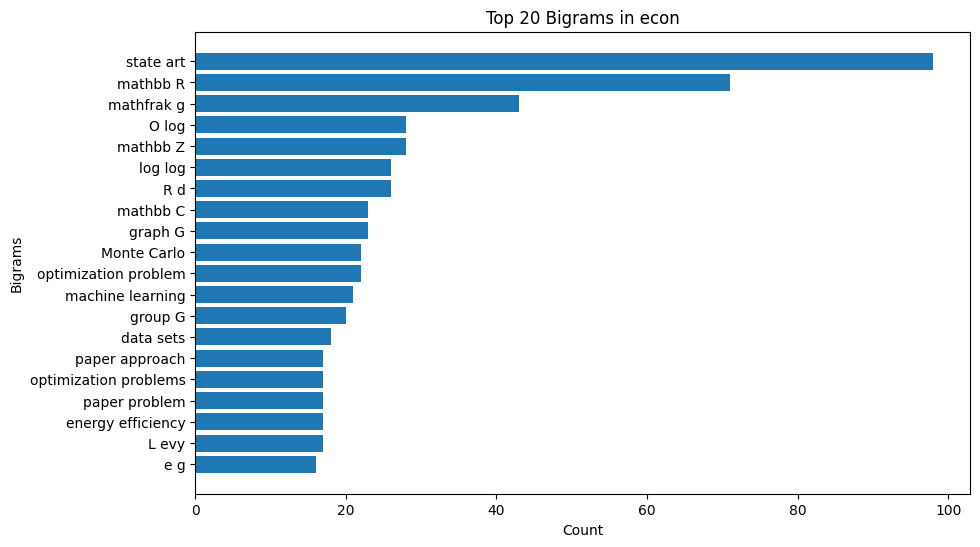

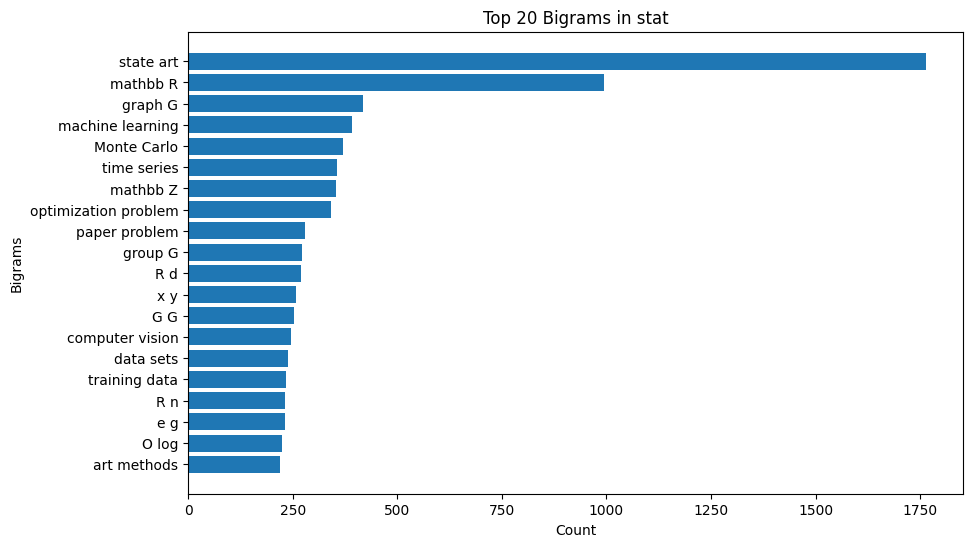

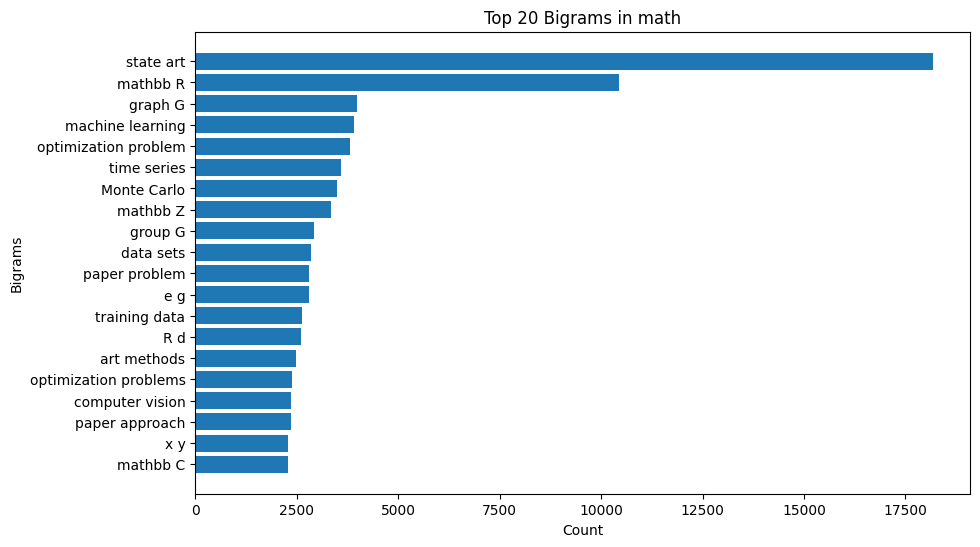

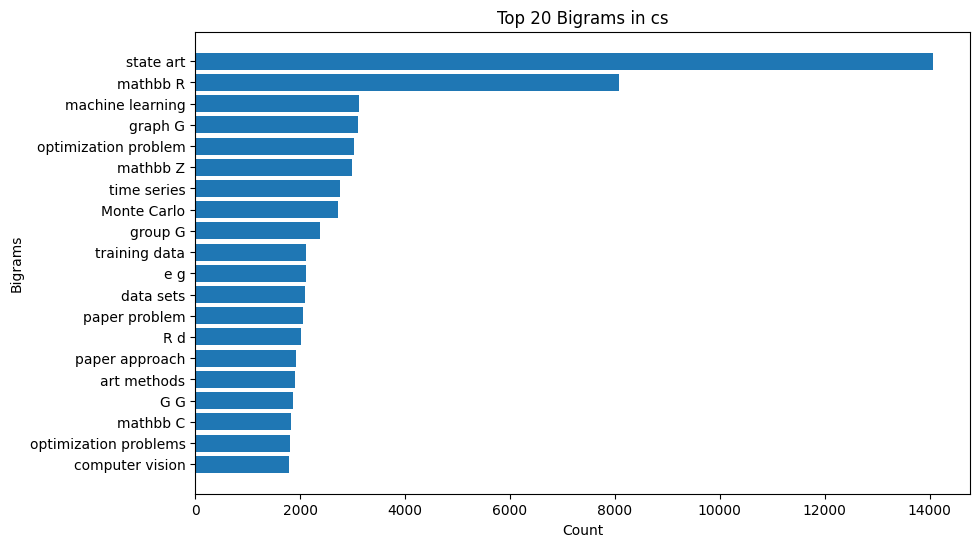

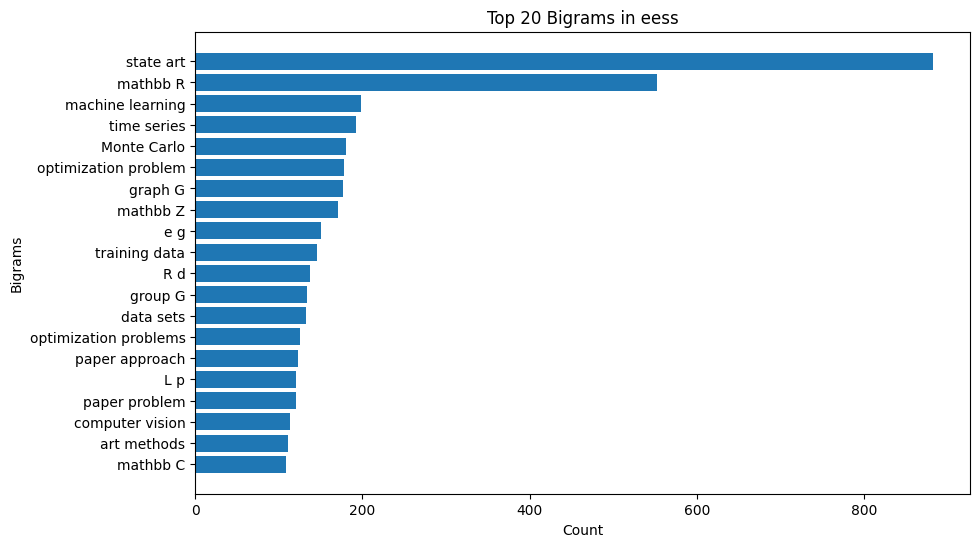

In [18]:
subjects = {'cs','math','stat','econ','eess'}
import matplotlib.pyplot as plt
for year in subjects:

    # Filter the data for the current year
    year_data = df_concat[df_concat['categories'] == year]

    # Flatten the list of bigrams for the current year
    all_bigrams = [bigram for bigrams in year_data['bigrams'] for bigram in bigrams]

    # Count the occurrences of each bigram
    bigram_counts = Counter(all_bigrams)

    # Get the top-20 bigrams for the current year
    top_20_bigrams = bigram_counts.most_common(20)
    # Extract the bigrams and their counts
    bigram_labels, bigram_values = zip(*top_20_bigrams)
    bigram_labels = [' '.join(label) for label in bigram_labels]

    # # Create a horizontal bar plot for the top-20 bigrams
    plt.figure(figsize=(10, 6))
    plt.barh(bigram_labels,bigram_values)
    plt.xlabel('Count')
    plt.ylabel('Bigrams')
    plt.title(f'Top 20 Bigrams in {year}')
    plt.gca().invert_yaxis()  # Invert the y-axis for better readability
    plt.show()
    plt.close()


# I notice that there are a lot of similarities, especially considering. A lot of the same word occurences that are present in econ are also present in other titles as well, such as machine learning, mathbb r(likely math r),optimization problem,and olog. This is somewhat suprising, as a lot of topics tend to overlap sometimes, especially since a lot of recent innovations in these technical fields(Computer Science, Math, Statistics, Economics, and EESS), tend to be driven by artifiicial intelligence, hence why a large number of research papers are published mentioning the respective terminology.